#### 人工神经网络分类器

In [76]:
import numpy as np

class ANNClassifier:
    def __init__(self, hidden_layer_sizes=(30, 30), eta=0.01,max_iter=500, tol=0.001):
        '''构造器'''
        # 各隐藏层节点个数
        self.hidden_layer_sizes = hidden_layer_sizes
        # 随机梯度下降学习率
        self.eta = eta
        # 随机梯度下降最大迭代次数
        self.max_iter = max_iter
        # 误差阈值
        self.tol = tol
    def _sigmoid(self, z):
        '''激活函数，计算节点输出'''
        return 1.0 / (1.0 + np.exp(-z))
    
    def _z(self, x, W):
        '''加权求和，计算节点净输入'''
        return x @ W
    
    def _error(self, y, y_pred):
        '''计算误差'''
        return np.sum((y - y_pred)**2)
    
    def _backpropagation(self, X, y):
        '''基于梯度下降反向传播'''
        
        m, n = X.shape
        _, n_out = y.shape
        
        #获得各层节点个数元组layer_sizes以及总数layer_n
        layer_sizes = self.hidden_layer_sizes + (n_out,)
        layer_n = len(layer_sizes)
        
        # 对于每一层, 将所有节点的权向量（以列向量的形式存为一个矩阵）,保存为W_list
        W_list = []
        li_size = n
        for lj_size in layer_sizes:
            W = np.random.rand(li_size + 1, lj_size) * 0.05
            W_list.append(W) # 初始权值矩阵
            li_size = lj_size
            
        # 创建梯度下降时所使用的列表
        in_list = [None] * layer_n
        z_list = [None] * layer_n
        out_list = [None] * layer_n
        delta_list = [None] * layer_n
        self.err_list = [] # 存储每次迭代的损失值
        # 随机梯度下降
        idx = np.arange(m)
        for n in range(self.max_iter):
            # 随机打乱训练集
            np.random.shuffle(idx)
            X, y = X[idx], y[idx]
            for x, t in zip(X,y):
                # 单个样本作为输入运行神经网络
                out = x
                for i in range(layer_n):
                    # 第 i-1 层输出添加x0=1, 作为第i层输入
                    in_ = np.ones(out.size + 1)
                    in_[1:] = out
                    # 计算第i层所有节点净输入
                    z = self._z(in_, W_list[i])
                    # 计算第i层各节点的输出值
                    out = self._sigmoid(z)
                    # 保存第i层节点输入，净输入， 输出
                    in_list[i], z_list[i], out_list[i] = in_, z, out
            # 反向传播计算各节点的delta
            # 输出层
            delta_list[-1] = out * (1.0 - out) * (t - out)
            # 隐藏层
            for i in range(layer_n - 2, -1, -1):
                out_i, W_j, delta_j = out_list[i], W_list[i+1], delta_list[i+1]
                delta_list[i] = out_i * (1.0 - out_i) * (W_j[1:] @ delta_j[:, None]).T[0]
                
            # 更新所有节点的权
            for i in range(layer_n):
                in_i, delta_i = in_list[i], delta_list[i]
                W_list[i] += in_i[:, None] * delta_i * self.eta

            # 计算训练误差
            y_pred = self._predict(X, W_list)
            err = self._error(y, y_pred)
            self.err_list.append(err)
            # print("权值矩阵",W_list)
            print("迭代次数: %s 损失值: %s"%(n,err))
            if err < self.tol:
                break
        self.n = n
        # 返回训练好的权矩阵列表
        return W_list
    def _predict(self, X, W_list, return_bin=False):
        '''预测内部接口'''
        
        layer_n = len(W_list)
        
        out = X
        for i in range(layer_n):
            # 第i-1层输出添加x0=1, 作为第i层输入
            m, n = out.shape
            in_ = np.ones((m , n + 1))
            in_[:, 1:] = out
            # 第i层节点的净输入
            z = self._z(in_, W_list[i])
            # 计算第i层所有节点输出值
            out = self._sigmoid(z)
        
        # 是否返回二进制编码的类标记
        if return_bin:
            # 输出最大的节点输出编码为1, 其他节点输出编码为0
            idx = np.argmax(out, axis=1)
            out_bin = np.zeros_like(out)
            out_bin[range(len(idx)), idx] = 1
            return out_bin
        return out
    def train(self, X, y):
        '''训练'''
        # 调用反向传播算法训练神经网络中所有节点的权
        self.W_list = self._backpropagation(X, y)
    def predict(self, X):
        '''预测'''
        return self._predict(X, self.W_list, return_bin=True)

#### 调用Numpy.genfromtxt函数加载`手写数字`数据集

训练集：https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra

测试集：https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes



In [77]:

# 训练集
data_train = np.genfromtxt('optdigits.tra', delimiter=',', dtype=float)
X_train,y_train = data_train[:, :-1], data_train[:, -1]
# 测试集
data_test = np.genfromtxt('optdigits.tes', delimiter=',', dtype=float)
X_test, y_test = data_test[:, :-1], data_test[:, -1]

#### 使用sklearn.preprocessing.StandardScaler对数据特征进行标准化处理

In [78]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train) # 使用训练集进行拟合
StandardScaler(copy=True, with_mean=True, with_std=True)
# 对训练集进行标准化
X_train_std = ss.transform(X_train)
#对测试集进行标准化
X_test_std = ss.transform(X_test)

##### 对于分类问题，神经网络的每一个输出节点对于应一个类别，则数据类型标记是`1 of n`形式的二进制编码，而目前训练数据集中的类型标记是int类型的数字，因此使用sklearn.preprocessing.LabelBinarizer对y_train进行`1 of n`编码。后由于模型预测是预测值也是`1 of n`编码，因此后面也需要调用`lb.inverse_tranform`方法将它们解码成int类型

In [79]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)

#### 模型的训练和测试
创建一个3层神经网络，输入层和输出层分别有64个节点和10个节点（由训练集64个特征和10个类别决定）；隐藏层结构包含100个节点（自行定义）
 - `hidden_layer_sizes` = (100,) 隐藏层为1层100个节点
 - `eta`=0.05 随机梯度下降的学习率
 - `max_iter`=500 迭代次数为500
 - `tol`=0.00001 判断收敛的误差阈值为0.00001

迭代次数: 0 损失值: 11504.024079043698
迭代次数: 1 损失值: 7050.262731555939
迭代次数: 2 损失值: 5298.600139242277
迭代次数: 3 损失值: 4622.085114607979
迭代次数: 4 损失值: 4491.54173973689
迭代次数: 5 损失值: 3783.362343119701
迭代次数: 6 损失值: 3617.3436327012128
迭代次数: 7 损失值: 3546.1296855547703
迭代次数: 8 损失值: 3756.681874613696
迭代次数: 9 损失值: 3571.917789111574
迭代次数: 10 损失值: 3502.213525465268
迭代次数: 11 损失值: 3477.0404829509507
迭代次数: 12 损失值: 3609.5145129321645
迭代次数: 13 损失值: 3511.3115121526344
迭代次数: 14 损失值: 3885.2208501725677
迭代次数: 15 损失值: 3545.7155549450144
迭代次数: 16 损失值: 3539.6946418894095
迭代次数: 17 损失值: 3493.458187534631
迭代次数: 18 损失值: 3473.2058299419396
迭代次数: 19 损失值: 3508.8956613993246
迭代次数: 20 损失值: 3557.586948260371
迭代次数: 21 损失值: 3521.1358914347134
迭代次数: 22 损失值: 3767.3270447339555
迭代次数: 23 损失值: 3536.287451546241
迭代次数: 24 损失值: 3538.025209405739
迭代次数: 25 损失值: 3494.024096580437
迭代次数: 26 损失值: 3480.459564854087
迭代次数: 27 损失值: 3470.4946750852623
迭代次数: 28 损失值: 3479.022383978339
迭代次数: 29 损失值: 3486.1119795326786
迭代次数: 30 损失值: 3474.8106807579575
迭代次

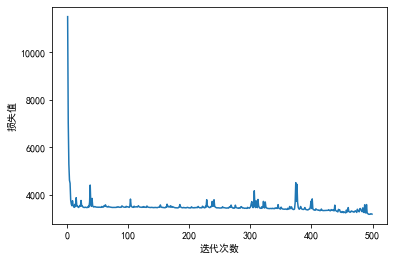

实际值: [0. 1. 2. ... 8. 9. 8.] 预测值：[0. 9. 4. ... 9. 9. 9.]
预测准确率为: 0.5147468002225932


In [80]:
from sklearn.metrics import accuracy_score # 计算预测准确率
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

clf = ANNClassifier(hidden_layer_sizes=(100,), eta=0.3,max_iter=500, tol=0.00001)
clf.train(X_train_std,y_train_bin)
y_pred_bin = clf.predict(X_test_std)

# 画损失值
n = clf.n # 迭代次数
n_list = np.linspace(1,n,n+1)
err_list = clf.err_list # 损失值列表
plt.figure()
plt.plot(n_list,err_list)
plt.xlabel("迭代次数");plt.ylabel("损失值")
plt.legend
plt.show()

y_pred = lb.inverse_transform(y_pred_bin) # 解码
accuracy = accuracy_score(y_test,y_pred)
print("实际值: %s 预测值：%s"%(y_test,y_pred))
print("预测准确率为: %s"%(accuracy))

#### 迭代次数和学习率均有调试，但是每次损失值下降到3000就停止了，原因不明
#### 检查了n遍网络也没有发现问题，编码解码也没问题，我怀疑是单层隐藏层的问题
#### 预测准确率时好是坏，总体是坏